# Import unwrap

In [3]:
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install --no-deps -U --no-cache git+https://github.com/jgraving/unwrap
!{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install fastprogress

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
  Cloning https://github.com/jgraving/unwrap to /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-9jj4pg9h
  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-9jj4pg9h
  Resolved https://github.com/jgraving/unwrap to commit 48e371b3a1a5af14f3f2e8fd0abe0b5c451be9bd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=13504 sha256=981b2774a556a55aab34c8471cd3c6936e66400e20c699b168616d1af7fb0d4a
  Stored in directory: /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-ephem-wheel-cache-qmks065b/wheels/47/bc/53/d9d6125a8e23f45962719159f75463c156228288997ba3313f
Successfully built unwrap


# Read in data

In [4]:
import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'SecurityLightBergsig.txt'
df = pd.read_csv(file_path, sep='\t')

# Create a binary indicator for the Light (1 for 'ON', 0 for 'OFF')
df['Light'] = df['Experiment'].apply(lambda x: 1 if 'ON' in x else 0)

# Convert the 'Heading' column from degrees to radians
df['Heading'] = pd.to_numeric(df['Heading'], errors='coerce')  # Convert non-numeric values (e.g., 'NA') to NaN
df['HeadingRadians'] = np.deg2rad(df['Heading'])

# Normalize the heading radians to be between -pi and pi
df['HeadingRadians'] = df['HeadingRadians'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# Keep only the relevant columns and drop rows with missing values
df = df[['Light', 'Beetle', 'Trial', 'HeadingRadians']].dropna().copy()
df.reset_index(drop=True, inplace=True)

# Rename columns: change 'Beetle' to 'Individual'
df = df.rename(columns={'Beetle': 'Individual'})
df['Individual'] = df['Individual'].astype('category')

df.head()


Light Individual  Trial  HeadingRadians
0      1          1      1        2.617994
1      1          1      2       -2.792527
2      1          1      3       -2.792527
3      1          1      4       -2.617994
4      1          1      5       -2.617994

# Plot data

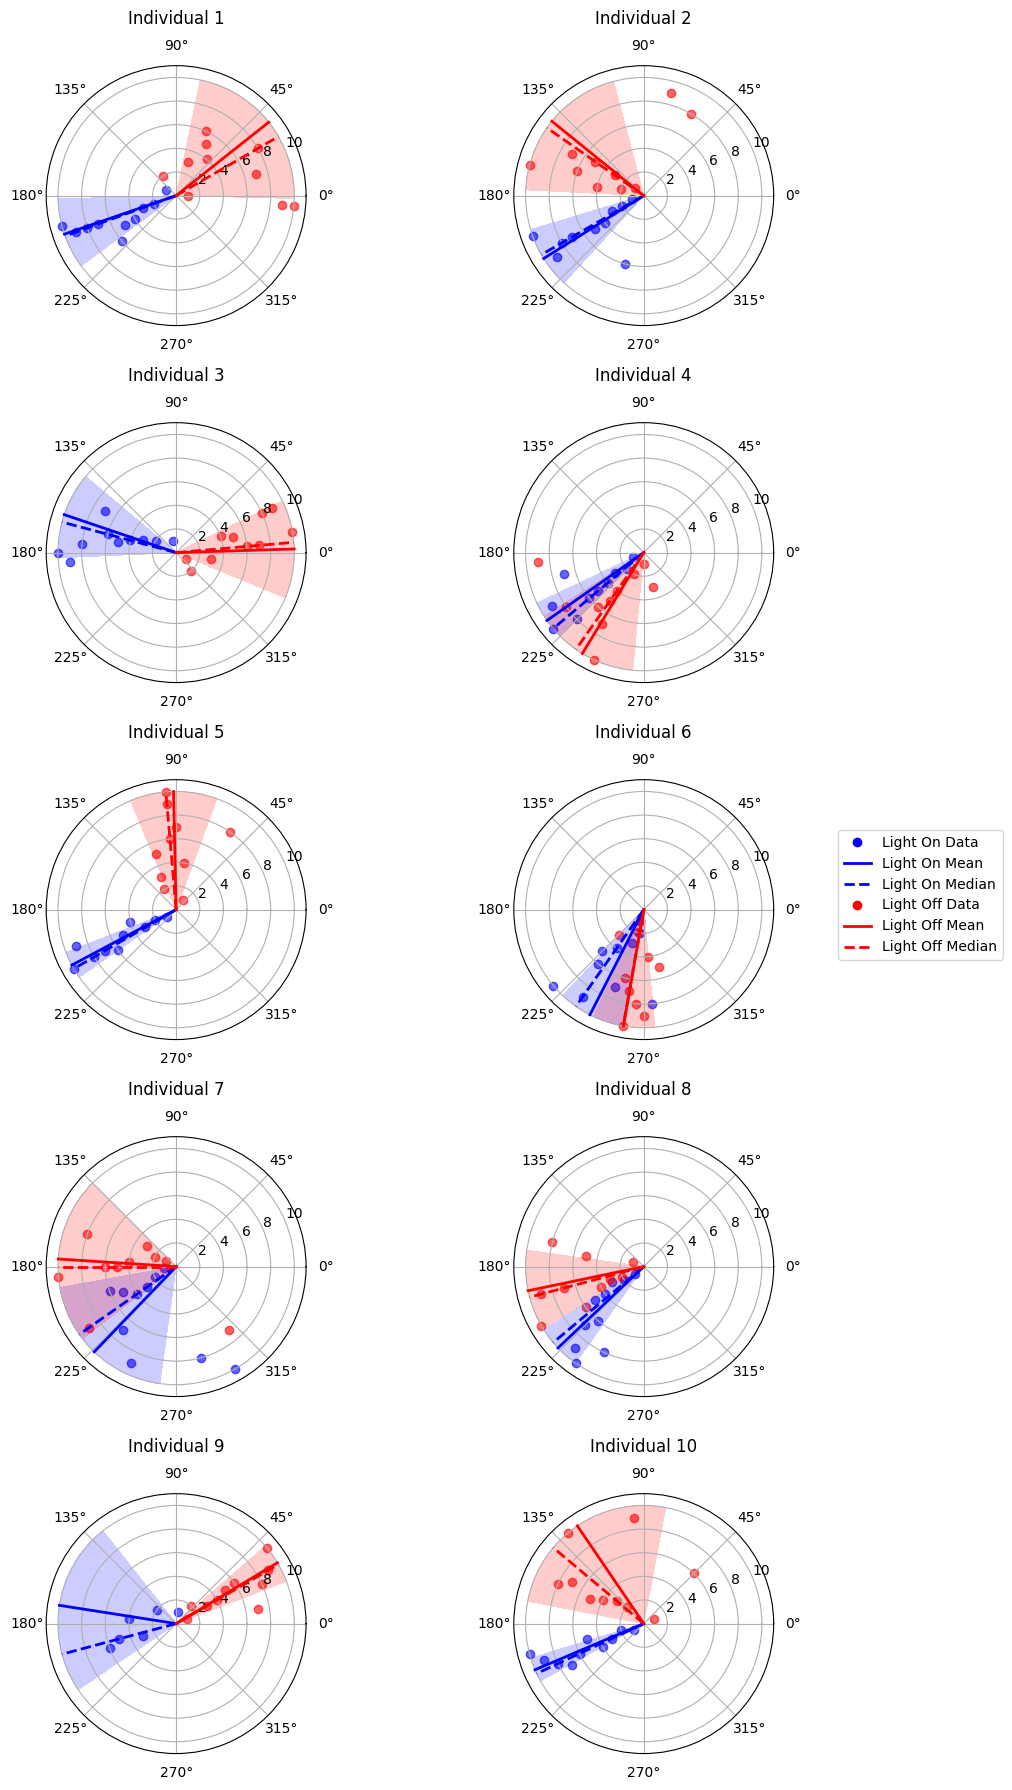

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Helper function to compute and plot summary statistics.
# It plots a solid vertical line at the circular mean and a dashed vertical line at the circular median,
# both in the specified color. It also fills the region ± the circular standard deviation.
def plot_summary_stats(ax, angles, radial_max, color):
    # Compute circular mean, median, and standard deviation.
    mean_val = circmean(angles, high=np.pi, low=-np.pi)
    median_val = circ_median(angles)
    std_val = circstd(angles, high=np.pi, low=-np.pi, normalize=True)
    
    # Plot mean (solid) and median (dashed).
    ax.plot([mean_val, mean_val], [0, radial_max], color=color, linewidth=2)
    ax.plot([median_val, median_val], [0, radial_max], color=color, linewidth=2, linestyle='--')
    
    # Fill the region between mean minus std and mean plus std.
    theta_vals = np.linspace(mean_val - std_val, mean_val + std_val, 100)
    r_vals = np.linspace(0, radial_max, 100)
    Theta, R = np.meshgrid(theta_vals, r_vals)
    ax.contourf(Theta, R, np.ones_like(Theta), alpha=0.2, colors=[color])
    
    return mean_val, median_val, std_val

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = 5, 2  # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = 10  # Maximum radial value

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    individual_data = df[df['Individual'] == individual]
    
    # Separate Light On and Light Off data (drop NaNs in HeadingRadians).
    data_on = individual_data[individual_data['Light'] == 1].dropna(subset=['HeadingRadians'])
    data_off = individual_data[individual_data['Light'] == 0].dropna(subset=['HeadingRadians'])
    
    # Scatter-plot data.
    plot_scatter(ax, data_on, 'HeadingRadians', 'Trial', 'blue', 'Light On')
    plot_scatter(ax, data_off, 'HeadingRadians', 'Trial', 'red', 'Light Off')
    
    # Plot summary statistics for each condition.
    if not data_on.empty:
        plot_summary_stats(ax, data_on['HeadingRadians'].values, radial_max, 'blue')
    if not data_off.empty:
        plot_summary_stats(ax, data_off['HeadingRadians'].values, radial_max, 'red')
    
    ax.set_title(f'Individual {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)

# Create a shared custom legend.
legend_handles = [
    # For Light On (blue)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Light On Data'),
    Line2D([0], [0], color='blue', lw=2, label='Light On Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Light On Median'),
    # For Light Off (red)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Light Off Data'),
    Line2D([0], [0], color='red', lw=2, label='Light Off Mean'),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Light Off Median'),
]

# Add one shared legend to the right of the figure.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.10, 0.5), fontsize='medium')

plt.tight_layout()
plt.show()


# Initial model

In [6]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula = bmb.Formula(
    "HeadingRadians ~ Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "Light": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
    ),
    "Light|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "Light|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model_tight = bmb.Model(
    formula,
    df,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_tight)

# Fit the model.
idata_tight = model_tight.fit(draws=1000, idata_kwargs={"log_likelihood": True})


       Formula: HeadingRadians ~ Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ Normal(mu: 0.0, sigma: 0.3141592653589793)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 1.6094379124341003, sigma: 0.1))
            Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3862943611198906, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.854586542131141, sigma: 1.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931471805599453, sigma: 0.1))
            kappa_Light|Individual ~ Normal(mu:

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, Light|Individual_sigma, Light|Individual_offset, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


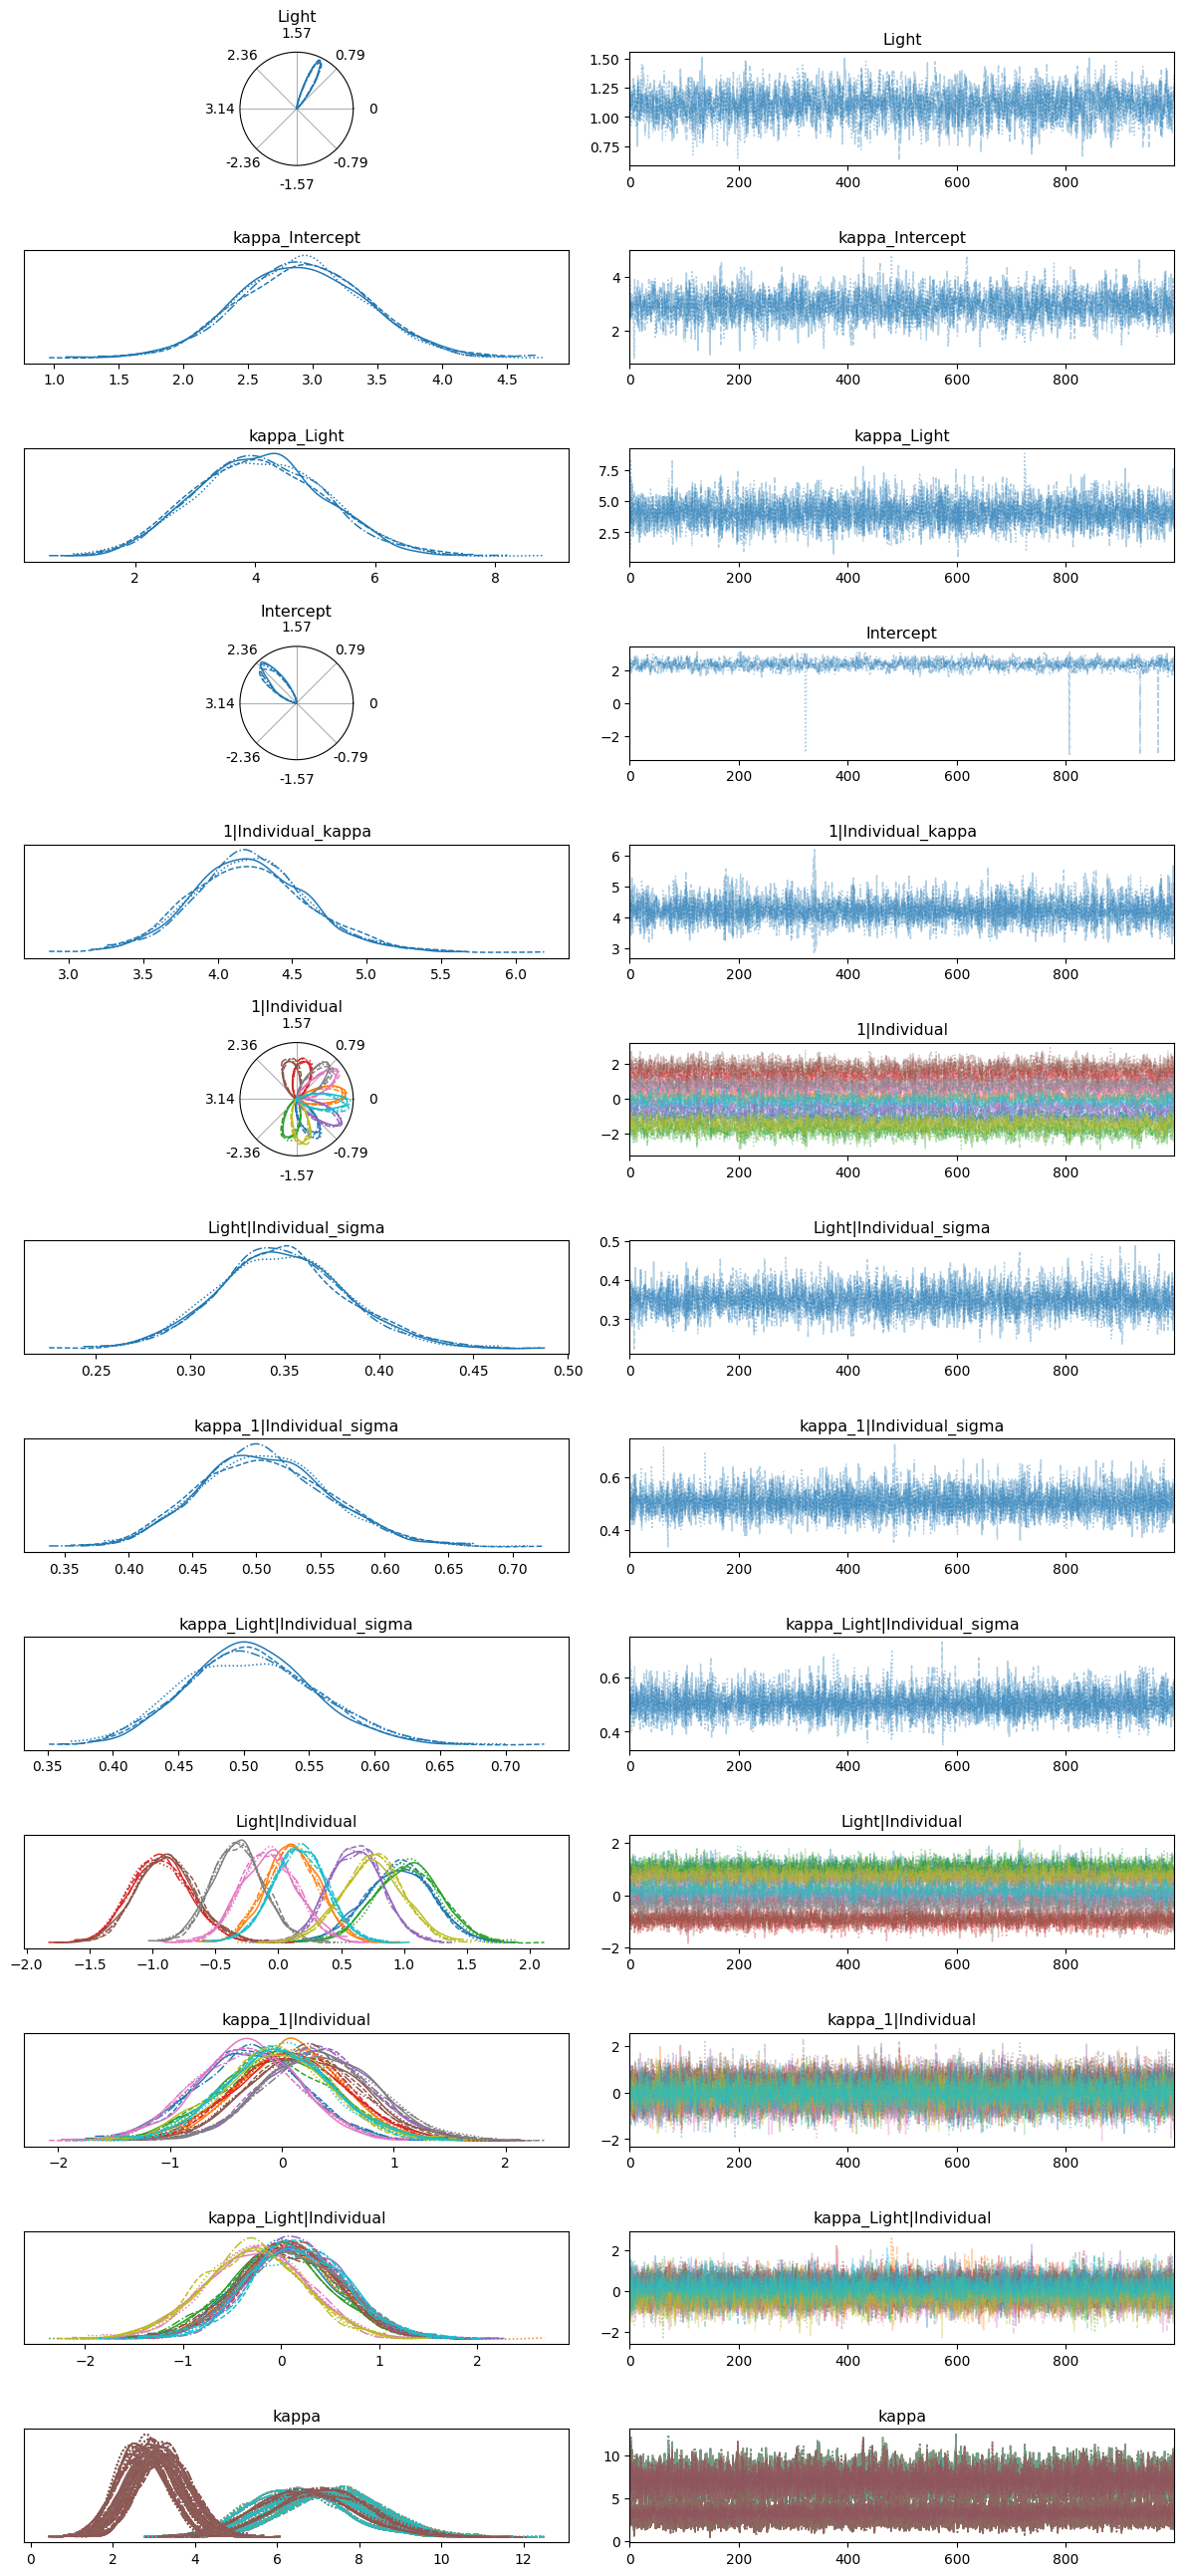

In [7]:
az.plot_trace(idata_tight, circ_var_names=["Light", "Intercept", "1|Individual"])
plt.tight_layout()
plt.show()

In [8]:
az.summary(
    idata_tight, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        2.346  0.250   1.876    2.808      0.007    0.031    1351.0   
Light            1.106  0.130   0.842    1.337      0.001    0.002    3239.0   
kappa_Intercept  2.925  0.502   2.034    3.896      0.009    0.007    3061.0   
kappa_Light      4.089  1.086   2.117    6.116      0.014    0.018    5906.0   

                 ess_tail  r_hat  
Intercept          2055.0    1.0  
Light              3076.0    1.0  
kappa_Intercept    2810.0    1.0  
kappa_Light        2775.0    1.0

In [9]:
az.summary(
    idata_tight, 
    circ_var_names=["Intercept", "Light", "1|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Light               1.106  0.130   0.842    1.337      0.001    0.002   
kappa_Intercept     2.925  0.502   2.034    3.896      0.009    0.007   
kappa_Light         4.089  1.086   2.117    6.116      0.014    0.018   
Intercept           2.346  0.250   1.876    2.808      0.007    0.031   
1|Individual_kappa  4.223  0.394   3.475    4.976      0.004    0.009   
...                   ...    ...     ...      ...        ...      ...   
kappa[191]          3.284  0.629   2.135    4.448      0.009    0.009   
kappa[192]          3.284  0.629   2.135    4.448      0.009    0.009   
kappa[193]          3.284  0.629   2.135    4.448      0.009    0.009   
kappa[194]          3.284  0.629   2.135    4.448      0.009    0.009   
kappa[195]          3.284  0.629   2.135    4.448      0.009    0.009   

                    ess_bulk  ess_tail  r_hat  
Light                 3239.0    3076.0    1.0  
kappa_Intercept       3061.0    2810.0    1.0  
kappa_Light           5906.0    2775.0    1.0  
Intercept             1351.0    2055.0    1.0  
1|Individual_kappa    8080.0    2527.0    1.0  
...                      ...       ...    ...  
kappa[191]            4450.0    3512.0    1.0  
kappa[192]            4450.0    3512.0    1.0  
kappa[193]            4450.0    3512.0    1.0  
kappa[194]            4450.0    3512.0    1.0  
kappa[195]            4450.0    3512.0    1.0  

[244 rows x 9 columns]

## Plot intitial model

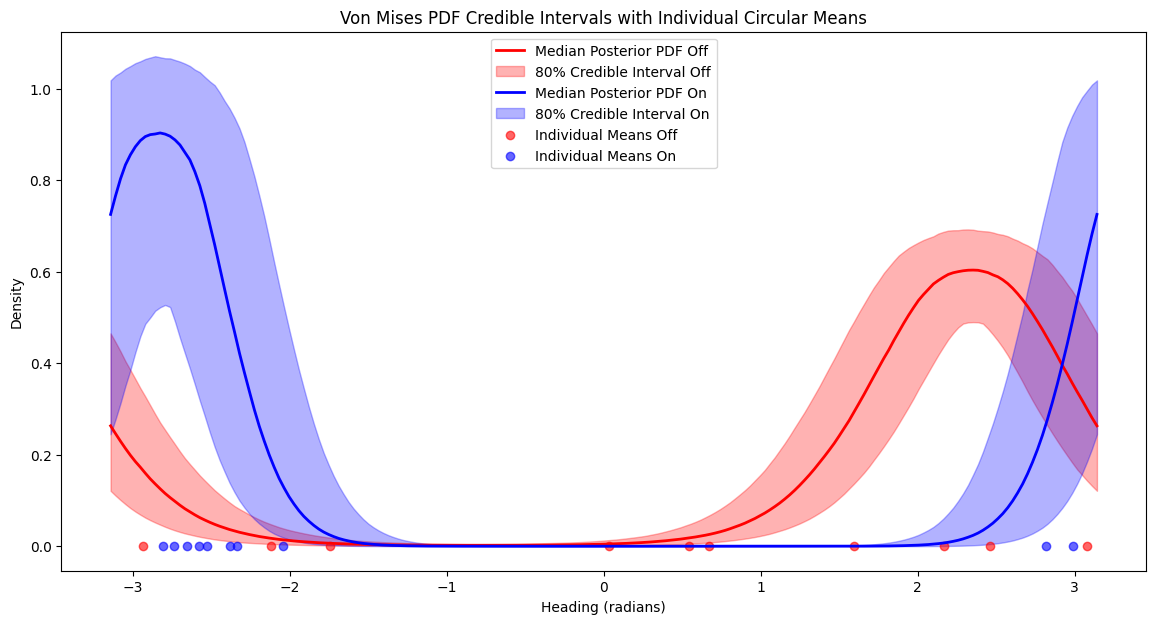

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises, circmean

# Import shifted_modulo and softplus from unwrap.link.numpy
from unwrap.link.numpy import shifted_modulo, softplus

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_tight.posterior['Intercept'].values          # fixed intercept for μ
mu_slope     = idata_tight.posterior['Light'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_tight.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slope     = idata_tight.posterior['kappa_Light'].values        # fixed slope for κ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_off_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_on_samples_all  = shifted_modulo((mu_intercept + mu_slope).flatten())
kappa_pop_off_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_on_samples_all  = softplus((kappa_intercept + kappa_slope).flatten())

# --------------------------------------------------
# Compute the von Mises PDF for each posterior sample at each theta.
# The resulting arrays have shape (num_samples, len(theta)).
# --------------------------------------------------
pdf_off = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_off_samples_all[:, None],
    loc=mu_pop_off_samples_all[:, None]
)
pdf_on = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_on_samples_all[:, None],
    loc=mu_pop_on_samples_all[:, None]
)

# For each theta, compute the median and the 95% credible interval.
median_pdf_off = np.median(pdf_off, axis=0)
lower_pdf_off  = np.percentile(pdf_off, 10, axis=0)
upper_pdf_off  = np.percentile(pdf_off, 90, axis=0)

median_pdf_on = np.median(pdf_on, axis=0)
lower_pdf_on  = np.percentile(pdf_on, 10, axis=0)
upper_pdf_on  = np.percentile(pdf_on, 90, axis=0)

# --------------------------------------------------
# Plot the median PDFs and fill between the 95% credible intervals.
# --------------------------------------------------
ax.plot(theta, median_pdf_off, color='red', lw=2, label='Median Posterior PDF Off')
ax.fill_between(theta, lower_pdf_off, upper_pdf_off, color='red', alpha=0.3,
                label='80% Credible Interval Off')

ax.plot(theta, median_pdf_on, color='blue', lw=2, label='Median Posterior PDF On')
ax.fill_between(theta, lower_pdf_on, upper_pdf_on, color='blue', alpha=0.3,
                label='80% Credible Interval On')

# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_off = individual_data.loc[individual_data['Light'] == 0, 'HeadingRadians'].dropna()
    headings_on  = individual_data.loc[individual_data['Light'] == 1, 'HeadingRadians'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_off = shifted_modulo(circmean(headings_off))
    individual_circmean_on  = shifted_modulo(circmean(headings_on))
    
    # Plot individual circular means.
    ax.scatter(individual_circmean_off, 0, color='red', alpha=0.6,
               label='Individual Means Off' if i == 0 else "")
    ax.scatter(individual_circmean_on, 0, color='blue', alpha=0.6,
               label='Individual Means On' if i == 0 else "")

ax.set_title('Von Mises PDF Credible Intervals with Individual Circular Means')
ax.set_xlabel('Heading (radians)')
ax.set_ylabel('Density')
ax.legend()
plt.show()


## Plot population-level predictions

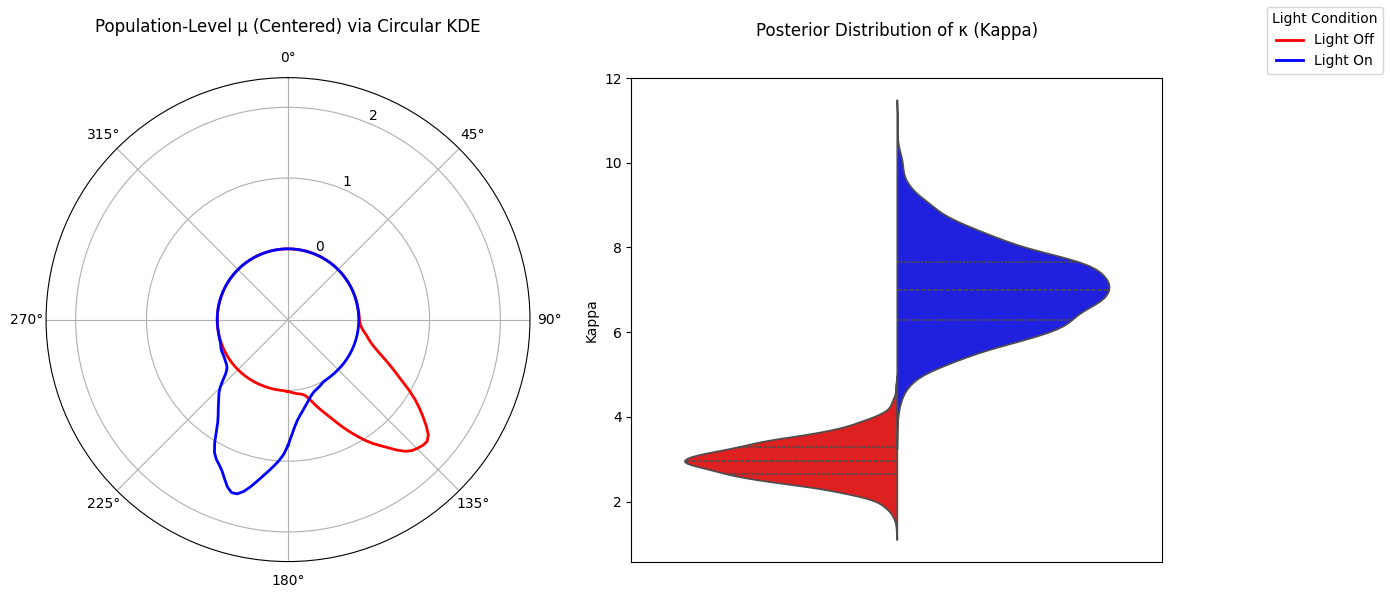

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import circmean, vonmises
from unwrap.link.numpy import shifted_modulo

# --------------------------------------------------
# Assume these arrays are computed from your posterior:
#   mu_pop_off_samples_all, mu_pop_on_samples_all,
#   kappa_pop_off_samples_all, kappa_pop_on_samples_all
# --------------------------------------------------

# ---------------------------
# Process μ (Mu) Samples
# ---------------------------
# Combine all μ samples to compute a common circular center.
mu_all = np.concatenate([mu_pop_off_samples_all, mu_pop_on_samples_all])
common_mu_center = circmean(mu_all, high=np.pi, low=-np.pi)

# Center the μ samples relative to the common center.
mu_off_centered = shifted_modulo(mu_pop_off_samples_all)
mu_on_centered  = shifted_modulo(mu_pop_on_samples_all)

# Set up an angular grid for the circular KDE.
theta = np.linspace(-np.pi, np.pi, 200)

# Choose a bandwidth (concentration) for the von Mises kernel.
kappa_bandwidth = 500  # Adjust as needed

# Compute the circular KDE for each condition.
# For each sample, evaluate the von Mises PDF at each theta, then average over samples.
kde_mu_off = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_off_centered[:, None]),
    axis=0
)
kde_mu_on = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_on_centered[:, None]),
    axis=0
)

# ---------------------------
# Process κ (Kappa) Samples
# ---------------------------
# For κ (a non-circular variable), no special centering is needed.
kappa_off = kappa_pop_off_samples_all
kappa_on  = kappa_pop_on_samples_all

# Create a DataFrame for the κ split violin plot.
df_kappa = pd.DataFrame({
    "Parameter": ["Kappa"] * (len(kappa_off) + len(kappa_on)),
    "Light": ["Light Off"] * len(kappa_off) + ["Light On"] * len(kappa_on),
    "Value": np.concatenate([kappa_off, kappa_on])
})

# --------------------------------------------------
# Create Subplots: a Polar Plot for μ and a Violin Plot for κ
# --------------------------------------------------
fig = plt.figure(figsize=(14, 6))

# (A) Polar subplot for μ.
ax1 = fig.add_subplot(1, 2, 1, projection='polar')
# Set axes to geographic format (clockwise, 0° at the top)
ax1.set_theta_zero_location('N')#place 0° at the top
ax1.set_theta_direction(-1)#reverse to clockwise
# Add an offset of 1 unit to the density so there's white space in the center.
ax1.plot(theta, kde_mu_off + 1, color='red', lw=2, label='Light Off')
ax1.plot(theta, kde_mu_on + 1, color='blue', lw=2, label='Light On')
ax1.set_title("Population-Level μ (Centered) via Circular KDE", va='bottom', pad=30)
# Adjust radial limits: add 1 (the offset) to the maximum density and a little extra space.
max_density = max(np.max(kde_mu_off), np.max(kde_mu_on))
ax1.set_rlim(0, 1 + max_density * 1.5)
ax1.set_rticks([1, 2, 3], [0, 1, 2])
# (B) Cartesian subplot for κ.
ax2 = fig.add_subplot(1, 2, 2)
sns.violinplot(x="Parameter", y="Value", hue="Light",
               data=df_kappa, split=True, inner="quartile",
               palette={"Light Off": "red", "Light On": "blue"},
               ax=ax2)
ax2.set_title("Posterior Distribution of κ (Kappa)", pad=30)
ax2.set_xlabel("")
ax2.set_ylabel("Kappa")
ax2.set_xticks([])
# --------------------------------------------------
# Create a Common Legend for Both Subplots
# --------------------------------------------------
# Remove individual legends from each subplot.
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
if ax2.get_legend() is not None:
    ax2.get_legend().remove()

# Extract legend handles and labels from one of the subplots.
handles, labels = ax1.get_legend_handles_labels()

# Place a common legend for the entire figure.
fig.legend(handles, labels, title="Light Condition", loc="upper right")

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend.
plt.show()


# Model with larger treatment effect on hyperparameters
Here we wider the priors on hyperparameters, putting a strong positive bias on the $\kappa_\mu$ hyperparameters since by default we expect strong agreement (partial pooling) for estimates across individuals.

In [19]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_wide = bmb.Formula(
    "HeadingRadians ~ Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_wide= {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    # "Light": bmb.Prior("Normal", mu=0, sigma= 0.75 * np.pi),#wider
    "Light": bmb.Prior("VonMises", mu=0, kappa= 1.0),#von Mises
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # 20251021 proposed shrinkage prior
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(10), sigma=0.6) # 20251022 a lot of divergences, try lower value?
    ),
    "Light|Individual": bmb.Prior(
        # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # my assumed potential for large changes 
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(3), sigma=3),#wider possible range
        # "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        "Light": bmb.Prior("Normal", mu=0, sigma=3.0),#slightly wider
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=3.0)#much wider
        ),
        "Light|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=1.0)#much wider
        ),
    },
}

# Build the model using the updated formula and priors.
model_wide = bmb.Model(
    formula_wide,
    df,
    family="vonmises",
    priors=priors_wide,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_wide)

# Fit the model.
idata_wide = model_wide.fit(draws=1000,
                            idata_kwargs={"log_likelihood": True},
                            sample_kwargs={
        "tune_kwargs": {
            "target_accept": 0.95  # Needs sampling with small steps
        }
    })


       Formula: HeadingRadians ~ Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ VonMises(mu: 0.0, kappa: 1.0)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 2.302585092994046, sigma: 0.6))
            Light|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4011973816621555, sigma: 0.6))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 2.9489308190572983, sigma: 3.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 3.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 3.0))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, Light|Individual_kappa, Light|Individual, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.


## Inspect summary


In [20]:
az.summary(
    idata_wide, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light", "1|Individual_kappa", "Light|Individual_kappa",
                "kappa_1|Individual_sigma", "kappa_Light|Individual_sigma"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                     2.301  0.597   1.175   -2.847      0.026   
Light                         1.287  0.293   0.744    1.851      0.007   
kappa_Intercept               4.861  1.023   3.119    6.975      0.025   
kappa_Light                   4.184  2.131   0.349    8.475      0.054   
1|Individual_kappa            1.473  0.428   0.738    2.286      0.007   
Light|Individual_kappa        2.725  0.730   1.475    4.111      0.013   
kappa_1|Individual_sigma      2.362  1.186   0.194    4.476      0.034   
kappa_Light|Individual_sigma  7.672  4.190   1.797   15.831      0.134   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.072    1072.0    1240.0   1.00  
Light                           0.008     730.0    1038.0   1.01  
kappa_Intercept                 0.018    1728.0    2317.0   1.00  
kappa_Light                     0.038    1602.0    1800.0   1.00  
1|Individual_kappa              0.007    3527.0    2684.0   1.00  
Light|Individual_kappa          0.012    2913.0    2404.0   1.00  
kappa_1|Individual_sigma        0.024    1038.0    1065.0   1.00  
kappa_Light|Individual_sigma    0.119     987.0    1671.0   1.00

In [21]:
az.summary(
    idata_wide, 
    var_names=["1|Individual", "Light|Individual",
                "kappa_1|Individual", "kappa_Light|Individual"],
    circ_var_names=["1|Individual", "Light|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1|Individual[1]             -1.455  0.645  -2.695   -0.183      0.029   
1|Individual[2]              0.151  0.600  -0.983    1.327      0.026   
1|Individual[3]             -2.185  0.627   2.793   -1.078      0.025   
1|Individual[4]              1.774  0.616   0.586    2.941      0.024   
1|Individual[5]             -0.660  0.604  -1.867    0.442      0.026   
1|Individual[6]              2.178  0.616   0.976   -2.946      0.026   
1|Individual[7]              0.694  0.614  -0.502    1.860      0.025   
1|Individual[8]              0.997  0.602  -0.176    2.106      0.025   
1|Individual[9]             -1.705  0.613  -2.907   -0.558      0.026   
1|Individual[10]            -0.117  0.599  -1.226    1.045      0.024   
Light|Individual[1]          1.316  0.390   0.581    2.038      0.009   
Light|Individual[2]         -0.036  0.330  -0.700    0.556      0.007   
Light|Individual[3]          1.375  0.355   0.748    2.091      0.006   
Light|Individual[4]         -1.595  0.343  -2.207   -0.917      0.008   
Light|Individual[5]          0.693  0.323   0.116    1.330      0.008   
Light|Individual[6]         -1.506  0.334  -2.104   -0.852      0.007   
Light|Individual[7]         -0.307  0.358  -0.970    0.375      0.007   
Light|Individual[8]         -0.673  0.323  -1.242   -0.023      0.007   
Light|Individual[9]          0.829  0.481  -0.104    1.748      0.011   
Light|Individual[10]         0.071  0.341  -0.565    0.723      0.007   
kappa_1|Individual[1]       -1.659  1.524  -4.627    0.853      0.038   
kappa_1|Individual[2]       -1.051  1.458  -3.917    1.614      0.031   
kappa_1|Individual[3]        0.368  1.701  -2.874    3.759      0.028   
kappa_1|Individual[4]        0.529  1.691  -2.758    3.730      0.030   
kappa_1|Individual[5]        1.549  1.993  -1.718    5.569      0.037   
kappa_1|Individual[6]        2.092  2.175  -1.583    6.270      0.044   
kappa_1|Individual[7]       -1.902  1.452  -4.728    0.562      0.034   
kappa_1|Individual[8]        1.698  2.067  -1.718    5.891      0.040   
kappa_1|Individual[9]        1.854  2.231  -1.400    6.587      0.051   
kappa_1|Individual[10]      -1.854  1.461  -4.672    0.654      0.036   
kappa_Light|Individual[1]    2.972  4.253  -4.178   11.404      0.084   
kappa_Light|Individual[2]    4.192  4.979  -3.897   14.283      0.100   
kappa_Light|Individual[3]   -0.868  3.714  -7.724    6.170      0.070   
kappa_Light|Individual[4]    8.014  7.313  -2.755   22.886      0.179   
kappa_Light|Individual[5]   10.125  9.032  -3.017   27.166      0.236   
kappa_Light|Individual[6]    1.480  4.737  -6.945   10.805      0.087   
kappa_Light|Individual[7]   -3.588  2.642  -8.651    1.348      0.060   
kappa_Light|Individual[8]    6.190  6.528  -3.813   19.501      0.147   
kappa_Light|Individual[9]   -8.818  4.707 -17.210   -1.251      0.132   
kappa_Light|Individual[10]  12.039  9.770  -1.298   29.665      0.259   

                            mcse_sd  ess_bulk  ess_tail  r_hat  
1|Individual[1]               0.042     765.0    1083.0   1.01  
1|Individual[2]               0.019     594.0     809.0   1.01  
1|Individual[3]               0.070    1070.0    1167.0   1.00  
1|Individual[4]               0.052     805.0     893.0   1.00  
1|Individual[5]               0.019     558.0     739.0   1.01  
1|Individual[6]               0.063    1044.0    1152.0   1.00  
1|Individual[7]               0.018     620.0     855.0   1.01  
1|Individual[8]               0.021     596.0     846.0   1.01  
1|Individual[9]               0.057     781.0     998.0   1.00  
1|Individual[10]              0.018     600.0     921.0   1.01  
Light|Individual[1]           0.013     853.0    1735.0   1.00  
Light|Individual[2]           0.007     964.0    1626.0   1.00  
Light|Individual[3]           0.007     949.0    1613.0   1.01  
Light|Individual[4]           0.007     914.0    1284.0   1.01  
Light|Individual[5]           0.007     887.0    1316.0   1.0

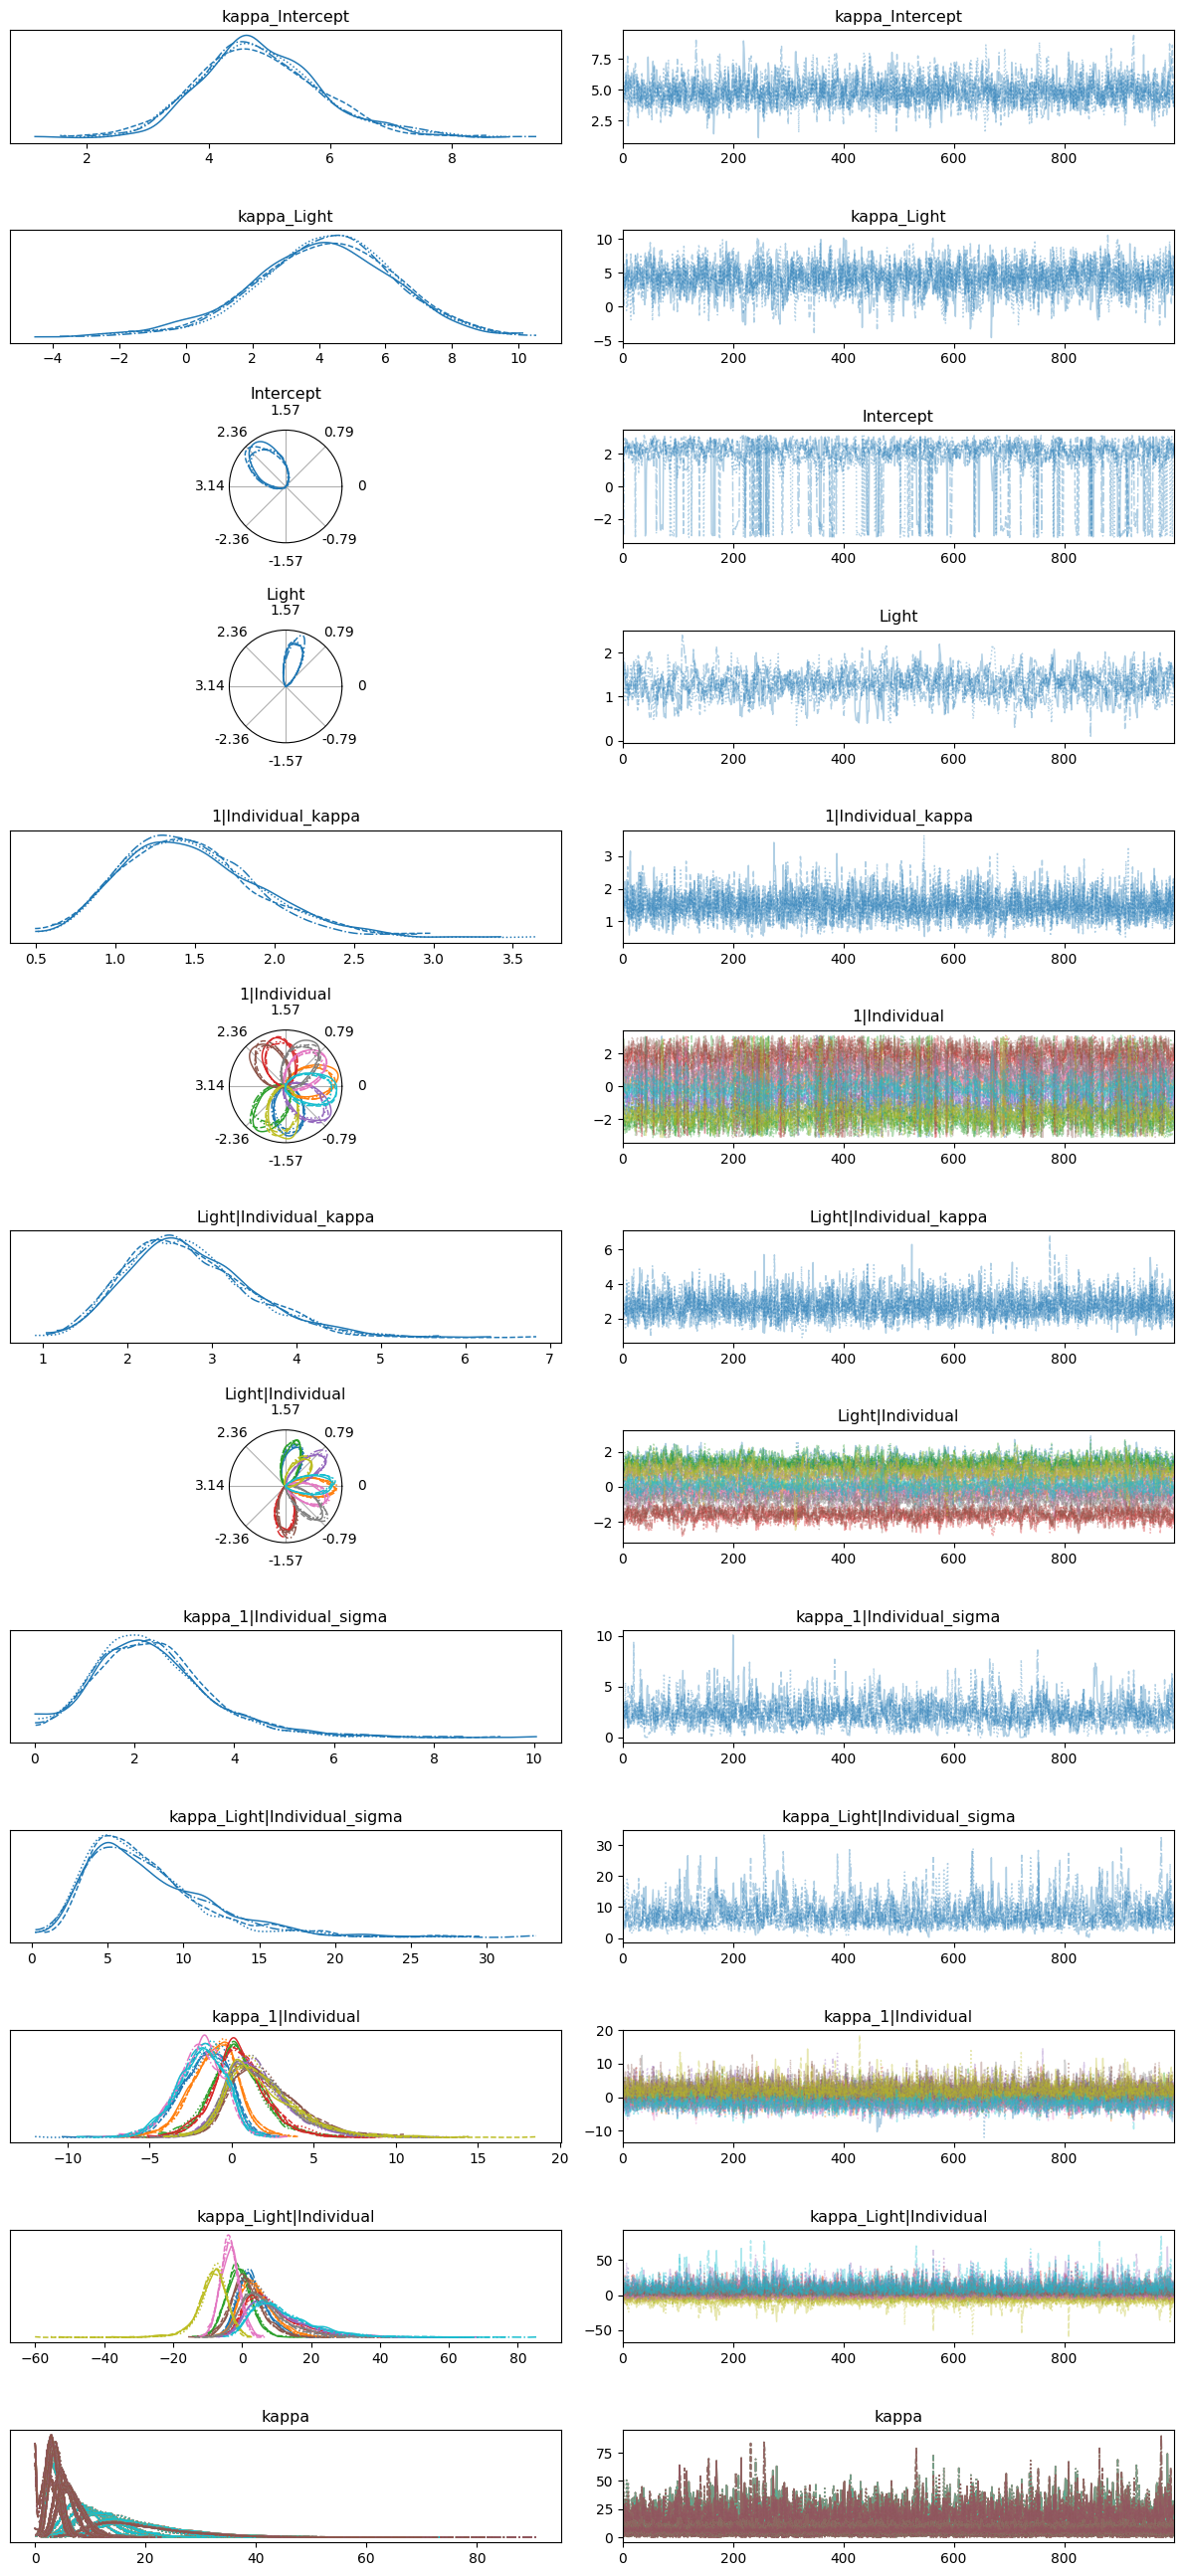

In [22]:
# varnms = ["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
#Specify which parameters are circular
cvars = ["Intercept", "Light", "1|Individual", "Light|Individual"]
#transform the circular data for interpretability
idata_wide_trans = idata_wide.copy() # set up a variable for transformed data
# for cvar in cvars:
#     idata_wide_trans.posterior[cvar] = -180*idata_wide_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_wide,
            #   var_names=varnms,
              circ_var_names=cvars,
              #circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model no change in $\kappa_\mu$
Our hypothesis is that turning on the light increased the correlation across individual headings. We could test this by excluding the effect of light on the population of individual headings.

In [ ]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_nolightkm = bmb.Formula(
    "HeadingRadians ~ Light + (1|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_nolightkm= {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "Light": bmb.Prior("VonMises", mu=np.pi/2, kappa= 0.5),#For this model this parameter is now difficult to estimate (as we would expect), loosening helps?
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(3), sigma=0.6) # 20251022 needs to be low to converge?
    ),
    # "Light|Individual": bmb.Prior(
    #     # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    #     "VonMises", mu=0, kappa=100 # the light has almost no effect on individual headings (Mardia SD≈6°)
    # ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(1.0), sigma=3.0),#narrower
        # "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        "Light": bmb.Prior("Normal", mu=0, sigma=1.0),#narrower
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=1.0)#narrower
        ),
        "Light|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=0.5)#narrower
        ),
    },
}

# Build the model using the updated formula and priors.
model_nolightkm = bmb.Model(
    formula_nolightkm,
    df,
    family="vonmises",
    priors=priors_nolightkm,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_nolightkm)

# Fit the model.
idata_nolightkm = model_nolightkm.fit(draws=1000,
                            idata_kwargs={"log_likelihood": True},
                            sample_kwargs={
        "tune_kwargs": {
            "target_accept": 0.97  # Set your desired value (e.g., 0.95)
        }
    })


       Formula: HeadingRadians ~ Light + (1|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ VonMises(mu: 0.0, kappa: 3.0)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 1.0986122886681098, sigma: 0.6))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 0.5413248546129181, sigma: 3.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 1.0))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 0.5))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
There were 536 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [42]:
az.summary(
    idata_nolightkm, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light", "1|Individual_kappa",
                "kappa_1|Individual_sigma"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                 2.062  0.878   1.004   -2.558      0.078    0.132   
Light                     1.537  0.849  -0.011    2.505      0.079    0.027   
kappa_Intercept           0.846  1.495  -2.080    3.619      0.050    0.030   
kappa_Light               0.421  0.999  -1.449    2.310      0.016    0.016   
1|Individual_kappa        3.255  1.480   1.047    6.065      0.096    0.034   
kappa_1|Individual_sigma  4.365  1.870   1.474    7.814      0.051    0.038   

                          ess_bulk  ess_tail  r_hat  
Intercept                    812.0     782.0   1.02  
Light                        111.0     508.0   1.02  
kappa_Intercept              836.0    2025.0   1.01  
kappa_Light                 4026.0    2659.0   1.00  
1|Individual_kappa           192.0     672.0   1.01  
kappa_1|Individual_sigma    1224.0    2059.0   1.00

In [43]:
az.summary(
    idata_wide, 
    var_names=["1|Individual", "Light|Individual",
                "kappa_1|Individual"],
    circ_var_names=["1|Individual", "Light|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|Individual[1]        -1.455  0.645  -2.695   -0.183      0.029    0.042   
1|Individual[2]         0.151  0.600  -0.983    1.327      0.026    0.019   
1|Individual[3]        -2.185  0.627   2.793   -1.078      0.025    0.070   
1|Individual[4]         1.774  0.616   0.586    2.941      0.024    0.052   
1|Individual[5]        -0.660  0.604  -1.867    0.442      0.026    0.019   
1|Individual[6]         2.178  0.616   0.976   -2.946      0.026    0.063   
1|Individual[7]         0.694  0.614  -0.502    1.860      0.025    0.018   
1|Individual[8]         0.997  0.602  -0.176    2.106      0.025    0.021   
1|Individual[9]        -1.705  0.613  -2.907   -0.558      0.026    0.057   
1|Individual[10]       -0.117  0.599  -1.226    1.045      0.024    0.018   
Light|Individual[1]     1.316  0.390   0.581    2.038      0.009    0.013   
Light|Individual[2]    -0.036  0.330  -0.700    0.556      0.007    0.007   
Light|Individual[3]     1.375  0.355   0.748    2.091      0.006    0.007   
Light|Individual[4]    -1.595  0.343  -2.207   -0.917      0.008    0.007   
Light|Individual[5]     0.693  0.323   0.116    1.330      0.008    0.007   
Light|Individual[6]    -1.506  0.334  -2.104   -0.852      0.007    0.007   
Light|Individual[7]    -0.307  0.358  -0.970    0.375      0.007    0.006   
Light|Individual[8]    -0.673  0.323  -1.242   -0.023      0.007    0.007   
Light|Individual[9]     0.829  0.481  -0.104    1.748      0.011    0.014   
Light|Individual[10]    0.071  0.341  -0.565    0.723      0.007    0.007   
kappa_1|Individual[1]  -1.659  1.524  -4.627    0.853      0.038    0.035   
kappa_1|Individual[2]  -1.051  1.458  -3.917    1.614      0.031    0.021   
kappa_1|Individual[3]   0.368  1.701  -2.874    3.759      0.028    0.030   
kappa_1|Individual[4]   0.529  1.691  -2.758    3.730      0.030    0.031   
kappa_1|Individual[5]   1.549  1.993  -1.718    5.569      0.037    0.037   
kappa_1|Individual[6]   2.092  2.175  -1.583    6.270      0.044    0.035   
kappa_1|Individual[7]  -1.902  1.452  -4.728    0.562      0.034    0.021   
kappa_1|Individual[8]   1.698  2.067  -1.718    5.891      0.040    0.036   
kappa_1|Individual[9]   1.854  2.231  -1.400    6.587      0.051    0.053   
kappa_1|Individual[10] -1.854  1.461  -4.672    0.654      0.036    0.022   

                        ess_bulk  ess_tail  r_hat  
1|Individual[1]            765.0    1083.0   1.01  
1|Individual[2]            594.0     809.0   1.01  
1|Individual[3]           1070.0    1167.0   1.00  
1|Individual[4]            805.0     893.0   1.00  
1|Individual[5]            558.0     739.0   1.01  
1|Individual[6]           1044.0    1152.0   1.00  
1|Individual[7]            620.0     855.0   1.01  
1|Individual[8]            596.0     846.0   1.01  
1|Individual[9]            781.0     998.0   1.00  
1|Individual[10]           600.0     921.0   1.01  
Light|Individual[1]        853.0    1735.0   1.00  
Light|Individual[2]        964.0    1626.0   1.00  
Light|Individual[3]        949.0    1613.0   1.01  
Light|Individual[4]        914.0    1284.0   1.01  
Light|Individual[5]        887.0    1316.0   1.01  
Light|Individual[6]        888.0    1300.0   1.00  
Light|Individual[7]       1256.0    2092.0   1.00  
Light|Individual[8]        884.0    1260.0   1.00  
Light|Individual[9]       1477.0    1433.0   1.00  
Light|Individual[10]      1060.0    1430.0   1.00  
kappa_1|Individual[1]     1609.0    2490.0   1.00  
kappa_1|Individual[2]     2197.0    3153.0   1.00  
kappa_1|Individual[3]     3854.0    3273.0   1.00  
kappa_1|Individual[4]     3288.0    3160.0   1.00  
kappa_1|Individual[5]     3153.0    3093.0   1.00  
kappa_1|Individual[6]     2281.0    3156.0   1.00  
kappa_1|Individual[7]     1815.0    2690.0   1.00  
kappa_1|Individual[8]     2688.0    3009.0   1.00  
kappa_1|Individual[9]     2004.0    2394.0   1.00  
kappa_1|Individual[10]    1611.0    2658.0   1.00

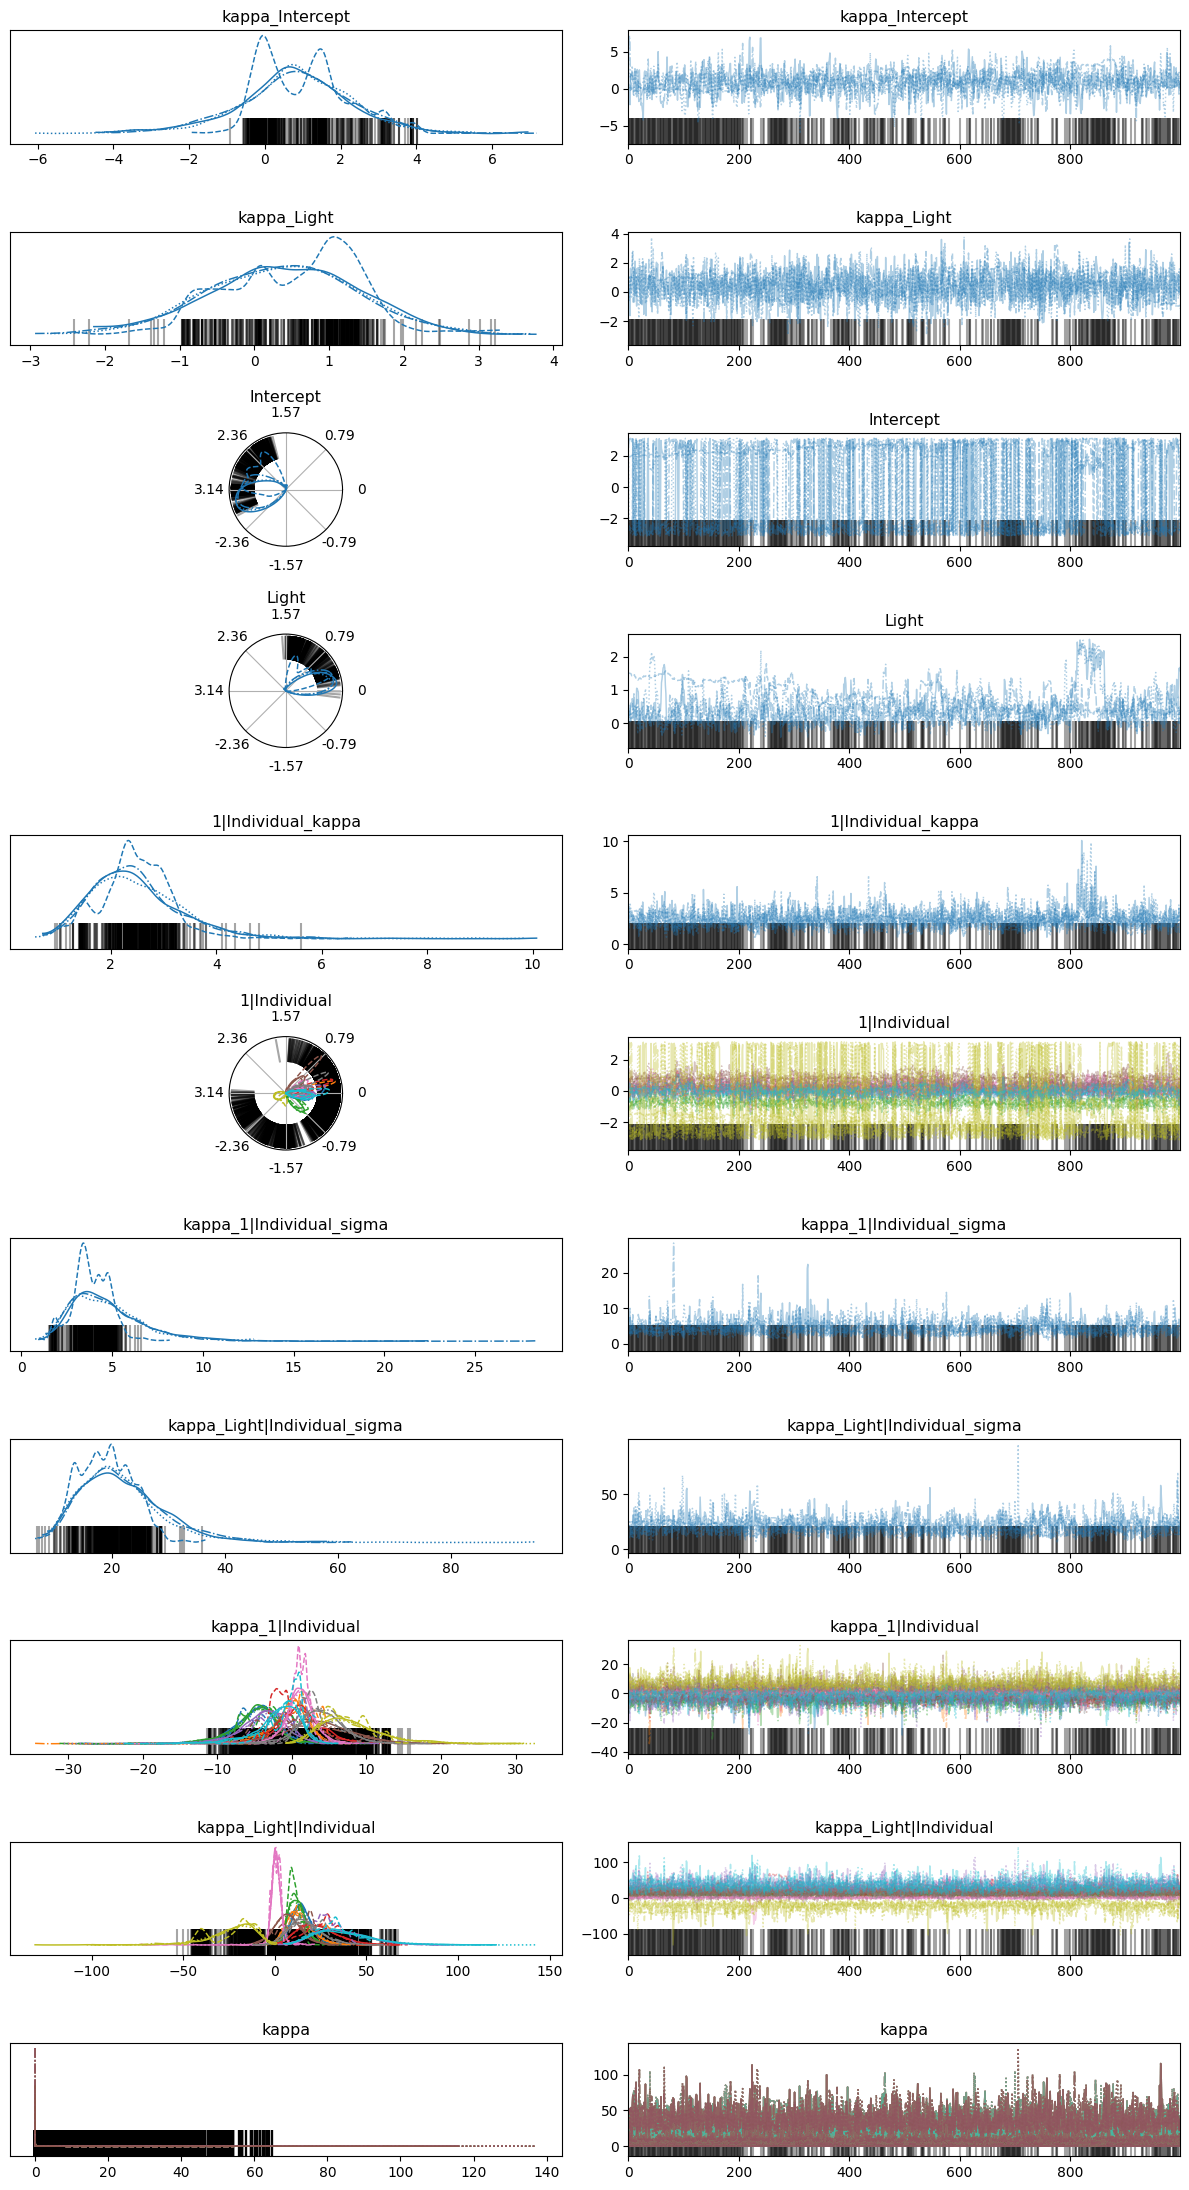

In [47]:
# varnms = ["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
#Specify which parameters are circular
cvars = ["Intercept", "Light", "1|Individual", "Light|Individual"]
#transform the circular data for interpretability
# for cvar in cvars:
#     idata_wide_trans.posterior[cvar] = -180*idata_wide_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_nolightkm,
            #   var_names=varnms,
              circ_var_names=cvars,
              #circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model comparison for hypothesis testing
Initially, just compare the restrictive and loosened prior models


In [14]:
#First the log likelihood function needs to be computed for each model and dataset

# model_tight.compute_log_likelihood(idata_tight)
# # model_wide.compute_log_likelihood(idata_wide)
# import pymc as pm
# pm.compute_log_likelihood(idata_tight, model = model_tight)
# pm.compute_log_likelihood(idata_wide, model = model_wide)



In [ ]:
#Calculate predictive power using LOO cross-validation
import pymc as pm
loo_tight = az.loo(idata_tight)
loo_wide = az.loo(idata_wide)
loo_nolightkm = az.loo(idata_nolightkm)
# loo_wide = az.reloo(loo_orig=loo_wide,
#                     wrapper=az.SamplingWrapper(model_wide),
#                     k_thresh = 0.7)

/Users/jamesfoster/Documents/Github/unwrap/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [ ]:
#print the results
print('\n----- Tight -----\n')
print(loo_tight)
print('\n----- Wide -----\n')
print(loo_wide)
print('\n----- No light $\kappa_\mu$ -----\n')
print(loo_nolightkm)
#some warnings in a small proportion of cases, but predictions are generally accurate

#compare, ranking models from best to worst
az.compare({'Tight':loo_tight,
            'Wide':loo_wide,
            'No light': loo_nolightkm
            }, 
            ic="loo")


----- Tight -----

Computed from 4000 posterior samples and 196 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -154.12    13.91
p_loo       21.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      196  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


----- Wide -----

Computed from 4000 posterior samples and 196 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -122.06    16.45
p_loo       37.55        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      190   96.9%
   (0.70, 1]   (bad)         3    1.5%
   (1, Inf)   (very bad)    3    1.5%



rank    elpd_loo      p_loo  elpd_diff    weight         se       dse  \
Wide      0 -122.058841  37.546322   0.000000  0.953758  16.454156  0.000000   
Tight     1 -154.123231  21.803329  32.064389  0.046242  13.911220  7.278551   

       warning scale  
Wide      True   log  
Tight    False   log